cuda:0


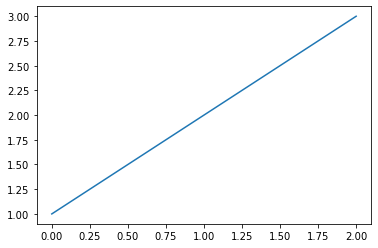

In [1]:
import importlib
from matplotlib import pyplot as plt
plt.plot([1,2,3])
from IPython.display import clear_output
import matplotlib
import numpy as np
import pandas as pd
import pdb
import time
from collections import deque
import torch
import cv2
from Environment.Env_new import RealExpEnv
from RL.sac import sac_agent, ReplayMemory, HerReplayMemory
from Environment.data_visualization import plot_graph, show_reset, show_done, show_step
from Environment.episode_memory import Episode_Memory
from Environment.get_atom_coordinate import atom_detection, blob_detection, get_atom_coordinate_nm
from skimage import morphology, measure
from Environment.createc_control import Createc_Controller
import glob
from collections import deque
matplotlib.rcParams['image.cmap'] = 'gray'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

In [428]:
import Environment.data_visualization
importlib.reload(Environment.data_visualization)
from Environment.data_visualization import plot_graph, show_reset, show_done, show_step

In [523]:
import Environment.Env_new
importlib.reload(Environment.Env_new)
from Environment.Env_new import RealExpEnv

In [30]:
import RL.sac
importlib.reload(RL.sac)
from RL.sac import sac_agent, ReplayMemory, HerReplayMemory

In [524]:
# run this if want to reset env but keep the memory
amd_accuracy = copy.copy(env.accuracy)
print(amd_accuracy)
amd_true_positive = copy.copy(env.true_positive)
print(amd_true_positive)
amd_true_negative = copy.copy(env.true_negative)
print(amd_true_negative)
amd = copy.copy(env.atom_move_detector)

[0.7910447761194029, 0.5384615384615384, 0.6923076923076923, 0.746268656716418, 0.8153846153846154, 0.9104477611940298, 0.9104477611940298, 0.9384615384615385, 0.9846153846153847, 0.9848484848484849, 0.9420289855072463, 0.8923076923076924, 0.9538461538461539, 0.9701492537313433, 0.9558823529411765, 0.9538461538461539, 0.9104477611940298, 0.9384615384615385, 0.9130434782608695, 0.9538461538461539, 0.9848484848484849, 0.9411764705882353, 0.8823529411764706, 0.9538461538461539, 0.9701492537313433, 0.9090909090909091, 0.9701492537313433, 0.9852941176470589, 0.9253731343283582, 0.9846153846153847, 0.9558823529411765, 1.0, 0.9538461538461539, 0.9545454545454546, 0.9393939393939394, 0.9573732718894009, 0.9242424242424242]
[1.0, 1.0, 1.0, 1.0, 1.0, 0.9836065573770492, 0.90625, 0.9365079365079365, 1.0, 0.984375, 0.9411764705882353, 0.90625, 0.953125, 0.9692307692307692, 0.9846153846153847, 1.0, 0.9230769230769231, 0.9516129032258065, 0.96875, 0.9836065573770492, 0.9841269841269841, 0.9545454545

succeed to connect
(128, 128)


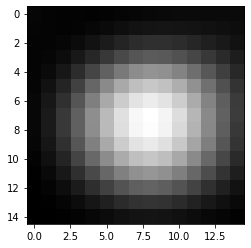

In [526]:
createc_controller = Createc_Controller(None, None, None, None)
img_forward = np.array(createc_controller.stm.scandata(1,4))
print(img_forward.shape)
top_left, w, h = (10,5), 15, 15
template = img_forward[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w]
plt.imshow(template)

In [527]:
#test offset extration
DAC_unit = 2**19
volt_unit = 10
Xgain = float(createc_controller.stm.getparam("GainX"))
Ygain = float(createc_controller.stm.getparam("GainY"))
Xpiezoconst = float(createc_controller.stm.getparam("Xpiezoconst"))
Ypiezoconst = float(createc_controller.stm.getparam("Ypiezoconst"))
x_nm = -0.1*Xpiezoconst*volt_unit*float(createc_controller.stm.getparam('OffsetX'))*Xgain/DAC_unit
y_nm = -0.1*Ypiezoconst*volt_unit*float(createc_controller.stm.getparam('OffsetY'))*Ygain/DAC_unit
print(x_nm, y_nm)

-17.239303588867188 -36.020179748535156


In [528]:
step_nm = 0.4
max_mvolt = 15 #min_mvolt = 0.5*max_mvolt
max_pcurrent_to_mvolt_ratio = 6E3 # min = 0.5*max
goal_nm  = 2
current_jump  = 3
pixel = 128

im_size_nm = 8.491

offset_nm = np.array([x_nm, y_nm])
manip_limit_nm = np.array([-19.5, -13.2, -34.5, -27.8]) #[left, right, up, down]
template_max_y = 25
scan_mV = 1000
max_len = 5
env = RealExpEnv(step_nm, max_mvolt, max_pcurrent_to_mvolt_ratio, goal_nm, 
                 template, current_jump, im_size_nm, offset_nm, manip_limit_nm, pixel, 
                 template_max_y, scan_mV, max_len, 'atom_move_detector.pth', bottom=False, random_scan_rate = 0.9)


succeed to connect
Load cnn weight


In [529]:
# run this if want to reset env but keep the memory
env.accuracy = amd_accuracy
env.true_positive = amd_true_positive
env.true_negative = amd_true_negative
env.atom_move_detector = amd

In [512]:
c_v, a_v = [], []
for c, a in zip(env.atom_move_detector.currents, env.atom_move_detector.atom_move_by):
    if (c is not None) and (a is not None):
        c_v.append(c)
        a_v.append(a)
    elif c is None:
        print('c None')
    elif a is None:
        print('a None')

c None
c None


In [513]:
env.atom_move_detector.currents = c_v
env.atom_move_detector.atom_move_by = a_v

In [450]:
for i, np_name in enumerate(glob.glob(folder_name+'/*.npy')):
    data = np.load(np_name,allow_pickle=True).item()
    transitions = data['transitions']
    for s, a, r, n, d, info in zip(transitions['state'], transitions['action'], transitions['reward'], 
                                   transitions['next_state'], transitions['done'], transitions['info']):
        mask = float(not d)
        memory.push(s, a, r, n, mask)
print(len(memory))

3142


In [530]:
# run this if want to reset env but keep the memory
buffer = memory.buffer
memory = HerReplayMemory(replay_size, env)
memory.buffer = buffer
print(len(memory))

3597


In [5]:
# ONLY RE-RUN if WANT TO RESET the AGENT
batch_size= 64
LEARNING_RATE = 0.0003
replay_size=1000000

agent = sac_agent(num_inputs = 4, num_actions = 6, action_space = None, device=device, hidden_size=256, lr=LEARNING_RATE,
                 gamma=0.9, tau=0.005, alpha=1)
agent.critic.load_state_dict(torch.load('{}/_critic_{}.pth'.format(folder_name,60)))
agent.policy.load_state_dict(torch.load('{}/_policy_{}.pth'.format(folder_name,60)))
agent.alpha = torch.load(''{}/_alpha_{}.pth'.format(folder_name,i_episode))
memory = HerReplayMemory(replay_size, env)

In [6]:
episode_memory = Episode_Memory()
folder_name = 'C:/LocalUserData/User-data/phys-asp-lab/auto_manipulation/training_0'

In [ ]:
episode_rewards, alphas, precisions, episode_lengths = [], [], [], []
avg_episode_rewards, avg_alphas, avg_precisions, avg_episode_lengths = [], [], [], []

In [452]:
c_k_min = 2500
eta_0 = 0.996
eta_T = 1.0
n_interactions = 500
max_ep_len = max_len
def sac_train(max_steps, num_episodes = 50, episode_start = 0):
    for i_episode in range(episode_start,episode_start+num_episodes):
        print('Episode:', i_episode)
        eta_t = np.minimum(eta_0 + (eta_T - eta_0)*(i_episode/n_interactions), eta_T)
        episode_reward, episode_steps = 0, 0
        done = False
        state, info = env.reset()
        show_reset(env.img_info, env.atom_start_absolute_nm, env.destination_absolute_nm,
                   env.template_nm, env.template_wh)
        episode_memory.update_memory_reset(env.img_info, i_episode, info)
        
        for step in range(max_steps):
            print('step:', step)
            action = agent.select_action(state)
            old_atom_nm = env.atom_absolute_nm
            next_state, reward, done, info = env.step(action)
            print('reward', reward)
            
            episode_steps+=1
            episode_reward+=reward
            mask = float(not done)
            memory.push(state,action,reward,next_state,mask)
            episode_memory.update_memory_step(state, action, next_state, reward, done, info)
            show_step(env.img_info, info['start_nm']+old_atom_nm, info['end_nm']+old_atom_nm,
                        env.atom_absolute_nm, env.atom_start_absolute_nm, 
                        env.destination_absolute_nm, action[4]*env.max_mvolt, 
                        action[5]*env.max_pcurrent_to_mvolt_ratio*action[4]*env.max_mvolt, 
                        env.template_nm, env.template_wh)
            print('Precision:', env.dist_destination)
            if done:
                episode_memory.update_memory_done(env.img_info, env.atom_absolute_nm, env.atom_relative_nm)
                episode_memory.save_memory(folder_name)
                
                atom_to_start = env.atom_relative_nm - env.atom_start_relative_nm
                print('Episode reward:', episode_reward)
                '''show_done(env.img_info, env.atom_absolute_nm, env.atom_start_absolute_nm, 
                          env.destination_absolute_nm, reward, env.template_nm, env.template_wh)'''
                break
            else:                
                state=next_state
             
        if (len(memory)>batch_size):
            episode_K = int(episode_steps)
            for k in range(episode_K):
                c_k = max(int(memory.__len__()*eta_t**(k*(max_ep_len/episode_K))), c_k_min)
                #c_k = memory.__len__()
                #print('TRAINING!')
                agent.update_parameters(memory, batch_size, c_k)
        
        episode_rewards.append(episode_reward)
        alphas.append(agent.alpha.item())
        precisions.append(env.dist_destination)
        episode_lengths.append(episode_steps)
        avg_episode_rewards.append(np.mean(episode_rewards[-min(100,len(episode_rewards)):]))
        avg_alphas.append(np.mean(alphas[-min(100, len(alphas)):]))
        avg_precisions.append(np.mean(precisions[-min(100, len(precisions)):]))
        avg_episode_lengths.append(np.mean(episode_lengths[-min(100, len(episode_lengths)):]))
        
        if (i_episode+1)%2==0:
            plot_graph(episode_rewards, precisions, alphas, episode_lengths,
                      avg_episode_rewards, avg_alphas, avg_precisions, avg_episode_lengths)
            
        if (i_episode)%20 == 0:
            torch.save(agent.critic.state_dict(), '{}/_critic_{}.pth'.format(folder_name,i_episode))
            torch.save(agent.policy.state_dict(), '{}/_policy_{}.pth'.format(folder_name,i_episode))
            torch.save(agent.alpha, '{}/_alpha_{}.pth'.format(folder_name,i_episode))


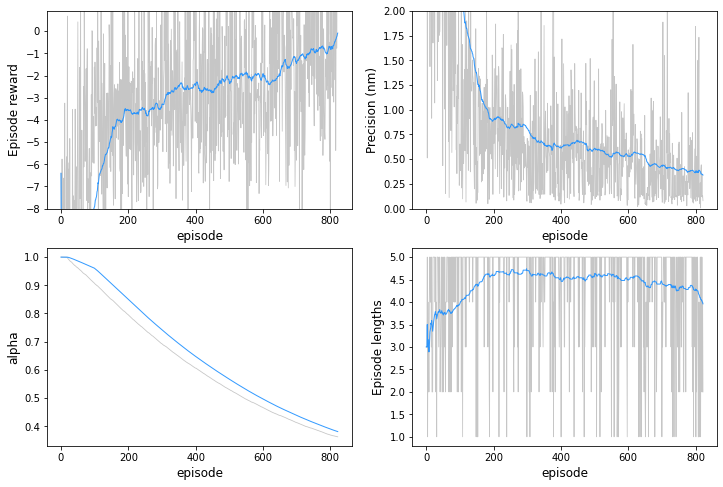

Episode: 816
goal_nm: 0.8147117015729095


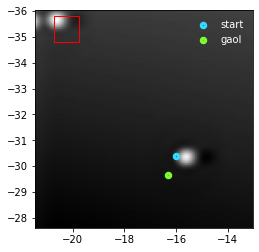

step: 0
83 90 76 102
Old prediction: True
Prediction: 0.99903584
cnn thinks there is atom movement
The scan will take 13.1 seconds
0.010946752892690995
0.010668774170100922
atom moves by: 1.1367486844513606
reward 0.6890497402278135


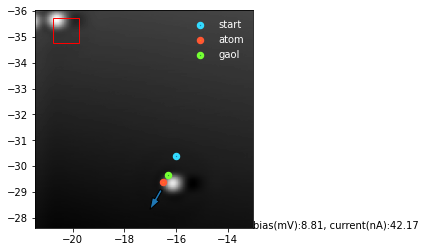

Precision: 0.3282653763872993
step: 1
74 101 83 104
Old prediction: False
Prediction: 0.9999839
cnn thinks there is atom movement
The scan will take 13.1 seconds
0.01095878904187106
0.010680587035776061
atom moves by: 1.034383933620315
reward -1.091342702208139


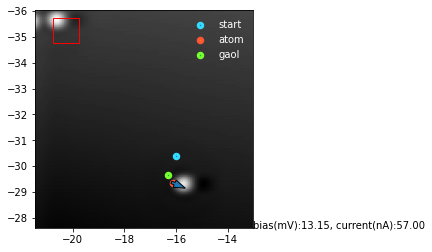

Precision: 0.3545720746232425
step: 2
79 97 80 98
Old prediction: False
Prediction: 0.99882394
cnn thinks there is atom movement
The scan will take 13.1 seconds


In [ ]:
sac_train(max_steps=max_len, episode_start = 804,num_episodes = 2000)

In [521]:
env.atom_absolute_nm = None

In [462]:
data = np.load(folder_name+'/00000.npy',allow_pickle=True).item()




[  -8.3361726  -217.95971278]
[  -6.47324667 -219.46342526]


In [463]:
dist_ds = []
for i, np_name in enumerate(glob.glob(folder_name+'/*.npy')):
    data = np.load(np_name,allow_pickle=True).item()
    end = data['episode_end_info']['atom_absolute_nm']
    goal = data['episode_start_info']['info']['goal_absolute_nm']
    dist_ds.append(np.linalg.norm(end - goal))

(0.0, 750.0)

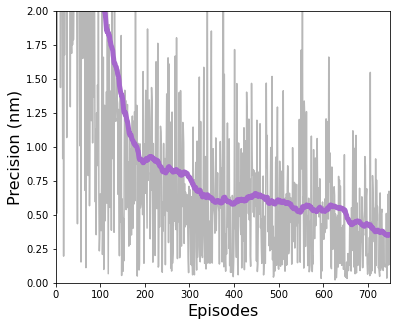

In [485]:
plt.subplots(figsize=(6,5))
plt.plot(dist_ds, color='#707070', alpha=0.5)
plt.plot(np.arange(100,len(dist_ds)-1),np.convolve(dist_ds, np.ones(100))[100:-100]/100, color='#A566CC', linewidth=5)
plt.xlabel('Episodes', fontsize=16)
plt.ylabel('Precision (nm)', fontsize=16)
plt.ylim([0, 2])
plt.xlim([0, 750])
# can we draw a horizontal line marking the 'ultimate precision'?